### Test - Synthetic Diagnostic + Interferometry

</b> Author:   </b>  Louis Evans     </br>
</b> Reviewer: </b>  Stefano Merlini

### Import relevant files:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#import vtk
#from vtk.util import numpy_support as vtk_np
import gc

import sys

#add path
sys.path.insert(0, '../../src/simulator')     # import path/to/synthpy

import config
config.jax_init()

import beam as beam_initialiser
import domain as d
import propagator as p
import diagnostics as diag
#import utils

import importlib
importlib.reload(beam_initialiser)
importlib.reload(d)
importlib.reload(p)
importlib.reload(diag)
#importlib.reload(utils)


Initialising jax...

jax:    0.6.2
jaxlib: 0.6.2
numpy:  1.26.4
python: 3.12.5 | packaged by Anaconda, Inc. | (main, Sep 12 2024, 18:27:27) [GCC 11.2.0]
device info: cpu-16, 16 local devices"
process_count: 1
platform: uname_result(system='Linux', node='computer', release='5.15.179-1-MANJARO', version='#1 SMP PREEMPT Thu Mar 13 13:45:22 UTC 2025', machine='x86_64')

Default jax backend: cpu
Available devices: [CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3), CpuDevice(id=4), CpuDevice(id=5), CpuDevice(id=6), CpuDevice(id=7), CpuDevice(id=8), CpuDevice(id=9), CpuDevice(id=10), CpuDevice(id=11), CpuDevice(id=12), CpuDevice(id=13), CpuDevice(id=14), CpuDevice(id=15)]


<module 'diagnostics' from '/home/administrator/Work/UROP_ICL_Internship/synthPy/examples/notebooks/../../src/simulator/diagnostics.py'>

To use the ray tracer, first create a 'domain', load the domain with an electron distribution, calculate electron gradients, initialise a beam, and solve!
\
\
The output can either be plotted, or passed further through ray optics for synthetic diagnostics

In [2]:
# define some extent, the domain should be distributed as +extent to -extent, does not need to be cubic
extent_x = 5e-3
extent_y = 5e-3
extent_z = 10e-3

n_cells = 512

#x = np.linspace(-extent_x, extent_x, n_cells)
#y = np.linspace(-extent_y, extent_y, n_cells)
#z = np.linspace(-extent_z, extent_z, n_cells)

probing_extent = extent_z
probing_direction = 'z'

lengths = 2 * np.array([extent_x, extent_y, extent_z])

#domain = d.ScalarDomain(x = x, y = y, z = z, extent = probing_extent, probing_direction = probing_direction)     # create domain
# Much simpler domain function, no longer needlessly takes in beam values, they are fully seperated
domain = d.ScalarDomain(lengths, n_cells, probing_direction, ne_type = "test_exponential_cos") # B_on = False by default

# load some external pvti
# import utils.handle_filetypes as load
# ne, dim, spacing = load.pvti_readin(filename)
# or load a test distribution

# only necessary to do so if you are not using the domain initialisation default distribution loading
# - that is the best option if using a test distribution

Predicted size in memory of domain: 512.0 MB
Free memory: 7.218231201171875 GB

Generating test exponential decay periodic -e field.

jax:    0.6.2
jaxlib: 0.6.2
numpy:  1.26.4
python: 3.12.5 | packaged by Anaconda, Inc. | (main, Sep 12 2024, 18:27:27) [GCC 11.2.0]
device info: cpu-16, 16 local devices"
process_count: 1
platform: uname_result(system='Linux', node='computer', release='5.15.179-1-MANJARO', version='#1 SMP PREEMPT Thu Mar 13 13:45:22 UTC 2025', machine='x86_64')


ValueError: The following fields were not initialised during __init__: {'region_count', 'dim_backup', 'length_backup'}

Solve gradients, initialise beam, and solve

In [ ]:
lwl = 1064e-9 #define laser wavelength

# initialise beam
Np = 512    # number of photons
divergence = 5e-5   # realistic divergence value
beam_size = extent_x    # beam radius
ne_extent = probing_extent  # so the beam knows where to initialise initial positions
beam_type = 'circular'

beam_definition = beam_initialiser.Beam(Np, beam_size, divergence, ne_extent, probing_direction = probing_direction, wavelength = lwl, beam_type = beam_type)

rf, _, duration = p.solve(beam_definition.s0, ne_extent, domain.dim, (domain.x, domain.y, domain.z), *p.calc_dndr(domain, lwl, keep_domain = True))#, parallelise = False, jitted = False)
print("\nCompleted ray trace in", np.round(duration, 3), "seconds.")


Size in memory of initial rays: 712 B

Running device: cpu, with: 16 cores.
NamedSharding(mesh=Mesh('rows': 16, axis_types=(Auto,)), spec=PartitionSpec('rows', None), memory_kind=unpinned_host)

jax compilation of solver took: 0.0007619857788085938 seconds


ValueError: Terms are not compatible with solver! Got:
ODETerm(vector_field=<function dsdt_ODE>)
but expected:
diffrax.AbstractTerm
Note that terms are checked recursively: if you scroll up you may find a root-cause error that is more specific.

Pass through ray optics: For Shadowgaphy, Schlieren, or Refractometry:


rf size expected: (512, 512)
rf after clearing nan's: (455, 455)


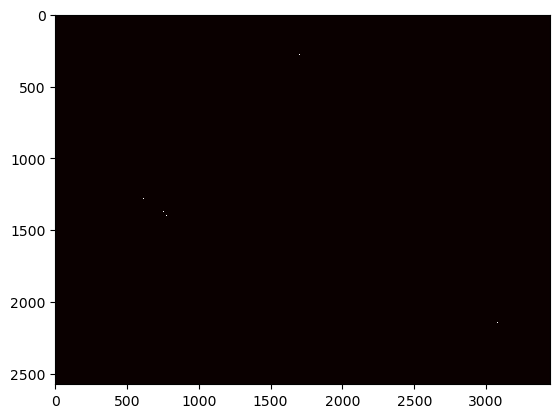

In [ ]:
#in the diagnostic initialisation, details on the lens configurations, and detector dimensions can be specified
refractometer = diag.Refractometry(lwl, rf)
refractometer.incoherent_solve()
# cam't clear_mem if you want to generate other graphs afterwards
refractometer.histogram(bin_scale = 1, clear_mem = False)

#information accessed by .H(istogram) , e.g plt.imshow(refractometer.H)

#plt.imshow(refractometer.H, cmap='hot', interpolation='nearest', clim = (0, 2))
plt.imshow(refractometer.H, cmap = 'hot', interpolation = 'nearest', clim = (0.5, 1))


rf size expected: (512, 512)
rf after clearing nan's: (455, 455)


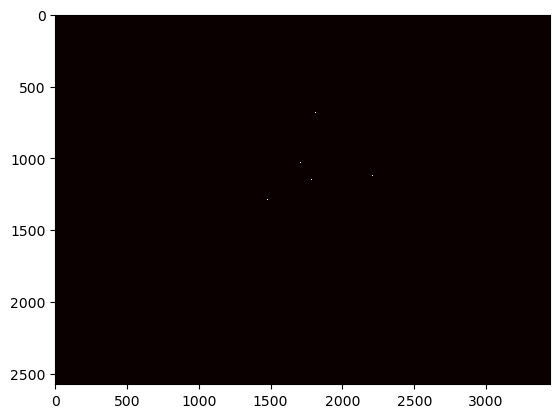

In [ ]:
shadowgrapher = diag.Shadowgraphy(lwl, rf)
shadowgrapher.single_lens_solve()
shadowgrapher.histogram(bin_scale = 1, clear_mem = False)

plt.imshow(shadowgrapher.H, cmap = 'hot', interpolation = 'nearest', clim = (0.5, 1))


rf size expected: (512, 512)
rf after clearing nan's: (345, 345)


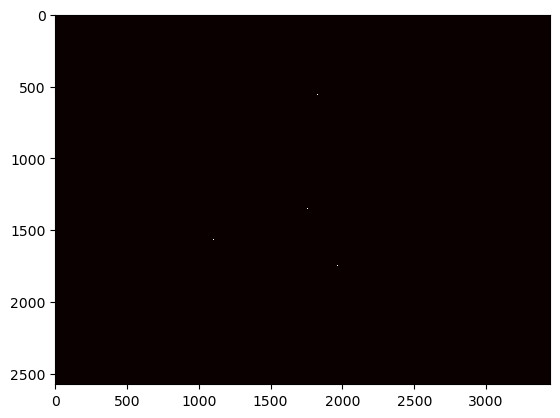

In [ ]:
schlierener = diag.Schlieren(lwl, rf)
schlierener.DF_solve()
schlierener.histogram(bin_scale = 1, clear_mem = True)

plt.imshow(schlierener.H, cmap = 'hot', interpolation = 'nearest', clim = (0.5, 1))

Synthetic Interferometry - This requires some extra steps in the ray tracing to include information on the phase and electric field values

In [ ]:
# No need to change the domain (now that code has been seperated out in restructure)



# load some external pvti

# import utils.handle_filetypes as load
# ne, dim, spacing = load.pvti_readin(filename)

# or load a test distribution



# initialise beam



# solve ray trace
tracer = p.Propagator(domain, probing_direction = probing_direction, inv_brems = False, phaseshift = True)

tracer.calc_dndr()
rf, Jf = tracer.solve(beam_definition.s0, return_E = True)

n_fringes = 10
deg = 10 #adjust number of fringes and tilt in degrees from the vertical exis

'''
interferometrer = diag.Interferometry(lwl, rf, Jf)
interferometrer.interfere_ref_beam(n_fringes, deg)

pattern = diag.Interferometry(lwl, rf, Jf)
#pattern = interferometrer
pattern.two_lens_solve()
pattern.interferogram(bin_scale = 1, clear_mem = True) #use interferogram instead of histogram

#get interferogram histogram with sh.H
plt.imshow(pattern.H, cmap = 'hot', interpolation = 'nearest')
'''

NameError: name 'n_refrac' is not defined


rf size expected: (512, 512)
rf after clearing nan's: (452, 452)


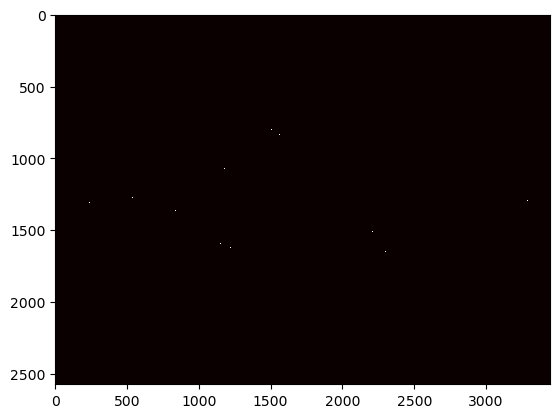

In [ ]:
refractometer = diag.Refractometry(lwl, rf, Jf)
refractometer.incoherent_solve()
refractometer.histogram(bin_scale = 1, clear_mem = False)

plt.imshow(refractometer.H, cmap = 'hot', interpolation = 'nearest', clim = (0.5, 1))


rf size expected: (512, 512)
rf after clearing nan's: (369, 369)


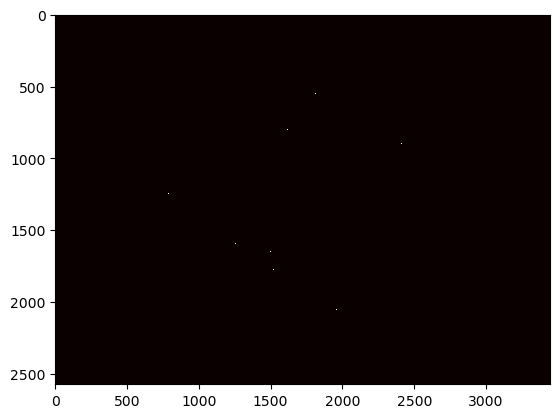

In [ ]:
refractometer = diag.Refractometry(lwl, rf, Jf)
refractometer.coherent_solve()
refractometer.histogram(bin_scale = 1, clear_mem = False)

plt.imshow(refractometer.H, cmap = 'hot', interpolation = 'nearest', clim = (0.5, 1))